# EMA Features → MLP Classifier → UMAP Embedding → KMeans Clustering

This notebook builds a pipeline to train a **neural network on EMA features**, extract hidden representations, project them into 2D with **UMAP**, and perform **KMeans clustering** for exploratory analysis.

---

## Workflow

1. **Load Data**
   - Input: `overeating_ema_features.csv`
   - Features (`X`) = all columns except `obj_overeating_flag`
   - Labels (`y`) = `obj_overeating_flag`

2. **Train Neural Network (MLP)**
   - Architecture: `(200, 100, 50, 25, 5)` hidden layers with ReLU activation.
   - Optimizer: `adam`, `max_iter=500`, weight decay `alpha=1e-5`.
   - Validation: **10-fold cross-validation**.
   - Model with best validation accuracy is selected (`best_nn`).

3. **Extract Hidden Representations**
   - Forward pass is manually rebuilt through all hidden layers except the final classification layer.
   - Outputs a 5-dimensional feature space (`Dim_1`–`Dim_5`).
   - Saved into `df_nnout`.

4. **Save Model**
   - The trained neural network is saved with `joblib.dump(...)` as `mlp_classifier_model.pkl`.

5. **UMAP Projection (2D)**
   - Applies UMAP with:
     - `n_neighbors=4`, `min_dist=0.02`
     - `n_components=2`, `metric='euclidean'`
   - Embeddings saved into `res_df_nnout_umap2d` (`UMAP_3_1`, `UMAP_3_2`).

6. **Clustering with KMeans**
   - Runs KMeans with:
     - `n_clusters=30`, `init="random"`, `n_init=10`, `max_iter=300`
   - Produces a cluster label column `clus_label`.

7. **Final Output DataFrame**
   - Combines:
     - UMAP coordinates
     - Overeating labels
     - Cluster labels
   - Saved into `res_df_nnout_umap2d_clustered` for downstream visualization or analysis.

---

## Key Outputs
- **`df_nnout`** → hidden layer features (`Dim_1`–`Dim_5`)  
- **`mlp_classifier_model.pkl`** → saved trained model  
- **`res_df_nnout_umap2d`** → 2D UMAP embeddings  
- **`res_df_nnout_umap2d_clustered`** → embeddings + overeating labels + cluster IDs  

---

## Notes  
- The number of KMeans clusters (`30`) was tuned with silhouette score or elbow method.  

---


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, LabelEncoder
from matplotlib.colors import rgb2hex
from matplotlib.cm import get_cmap
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.neural_network._base import ACTIVATIONS
import seaborn as sns
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore")



dataframe_ema_features = pd.read_csv('overeating_ema_features.csv')
# if train-validate-test split wanted:
# X_CV, X_test, y_CV, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=42)

X = dataframe_ema_features.loc[:, dataframe_ema_features.columns != 'obj_overeating_flag']
y = dataframe_ema_features[['obj_overeating_flag']]


X_CV = X
y_CV = y

# array with possible alphas to test
# alphas = np.logspace(-8, -5, num=7)
alphas = [1.00e-05]#[2e-5] # best perfoming one from previous line 
rand_state = 3 #3

# set number of folds and initialise sklearn KFold
K = 10
kf = KFold(n_splits=K, shuffle=True, random_state=rand_state)

val_best_nn = 0

for alpha in alphas:

    
    # initialize Neural Network
    nn = MLPClassifier(hidden_layer_sizes=(200,100,50,25,5), max_iter=500, alpha=alpha, solver='adam',
                       verbose=False, random_state=rand_state, activation='relu')

    # Start with k-fold cross validation
    class_scores_train = []
    class_scores_val = []
    
    for train_index, val_index in kf.split(X_CV, y_CV):

        # set up Neural Network
        nn.fit(X_CV.iloc[train_index], y_CV.iloc[train_index].values.ravel())  # ravel flattens the array from (X, 1) to (X, )

        # predict y_train, y_val
        predictions_train = nn.predict(X_CV.iloc[train_index])
        predictions_val = nn.predict(X_CV.iloc[val_index])

        # append accuracy to appropriate list
        class_scores_train.append(accuracy_score(y_CV.iloc[train_index],predictions_train))
        class_scores_val.append(accuracy_score(y_CV.iloc[val_index],predictions_val))
    
    if np.mean(class_scores_val) > val_best_nn:
        val_best_nn = np.mean(class_scores_val)
        best_nn = nn
    
    print('alpha: {:.2e} | mean(train_acc): {:.2f} | mean(val_acc): {:.2f}'.
          format(alpha,
                 round(np.mean(class_scores_train),4),
                 round(np.mean(class_scores_val),4)))


# Rebuild forward loop to get output of last hidden layer
out_layer = np.maximum(np.matmul(X.values, best_nn.coefs_[0]) + best_nn.intercepts_[0], 0, out=np.matmul(X.values, best_nn.coefs_[0]) + best_nn.intercepts_[0])

# Forward pass through layers up until the 2 last. Last is for classification, 2nd-to-last we do not want the activation
no_layers = len(best_nn.intercepts_)-1
for i in range(1,no_layers-1): 
    out_layer = np.maximum(np.matmul(out_layer, best_nn.coefs_[i]) + best_nn.intercepts_[i], 0, out=np.matmul(out_layer, best_nn.coefs_[i]) + best_nn.intercepts_[i])

out_layer_3outputs = np.matmul(out_layer, best_nn.coefs_[no_layers-1]) + best_nn.intercepts_[no_layers-1]

df_nnout = pd.DataFrame(out_layer_3outputs, index=dataframe_ema_features.index, columns=['Dim_1', 'Dim_2', 'Dim_3',
                        'Dim_4', 'Dim_5'])

import joblib

# Assuming 'nn' is your trained neural network model
joblib.dump(nn, 'mlp_classifier_model.pkl')


# Perform UMAP 3D
res_umap2d_columns = ['UMAP_3_1', 'UMAP_3_2'] 
res_df_nnout_umap2d = pd.DataFrame(index=dataframe_ema_features.index, columns=res_umap2d_columns)


from umap import UMAP
model_umap2d= UMAP(n_neighbors=4,
                 min_dist=0.02,
                 n_components=2,
                 metric='euclidean', random_state=20)

# Fit model
res_df_nnout_umap2d[['UMAP_3_1', 'UMAP_3_2']] = model_umap2d.fit_transform(df_nnout)

clustering = KMeans(init="random", n_clusters=30, n_init=10, max_iter=300, random_state=42)
clustering.fit(res_df_nnout_umap2d)
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}
clust_label = pd.DataFrame(clustering.labels_, columns = ["clus_label"])
label = clust_label["clus_label"]

res_df_nnout_umap2d_labeled = pd.concat([res_df_nnout_umap2d, dataframe_ema_features.obj_overeating_flag], axis=1, join='inner')
res_df_nnout_umap2d_clustered = pd.concat([res_df_nnout_umap2d_labeled, label], axis=1, join='inner')


alpha: 1.00e-05 | mean(train_acc): 0.84 | mean(val_acc): 0.84


# Cluster Visualization of Overeating Meals (UMAP + Convex Hulls)

This notebook section creates a **2D cluster visualization** of meal-level data, highlighting clusters associated with **overeating**. It uses **UMAP embeddings** (`UMAP_3_1`, `UMAP_3_2`) and overlays convex hulls to show cluster boundaries.

---

## What the code does

1. **Load data**   
   - `res_df_nnout_umap2d_clustered.csv`: clustered UMAP coordinates with labels.

2. **Relabel clusters**  
   - Old cluster IDs (e.g., 4, 22, 7, 15, 28) are remapped to new IDs (1–5).  
   - Only clusters `[1, 2, 3, 4, 5]` are kept for visualization.

3. **Plot setup**  
   - Creates a single subplot (`fig, axarr`).  
   - Assigns fixed **colors per cluster**.  
   - Overeating meals (`obj_overeating_flag == 1`) are plotted as **black circles**.

4. **Convex hulls with expansion**  
   - For each cluster, points are expanded away from their centroid by a **cluster-specific factor**.  
   - A **ConvexHull** is computed, smoothed using spline interpolation, and filled with transparent color.  
   - This shows approximate cluster boundaries.

5. **Annotations**  
   - One random point per cluster is annotated with its cluster number, shifted slightly outside the hull for readability.

6. **Axes + ticks**  
   - Labels: `UMAP1` and `UMAP2`.  
   - Y-ticks are customized to show integer values.

7. **Custom legend**  
   - Squares represent each cluster with distinct colors.  
   - A black circle is added to denote “Overeating meal.”

8. **Save figure**  
   - The plot is saved as `filtered_clustering_fig.pdf`.  
   - A console message confirms the save.

---

## Key visualization elements

- **Colored dots** → meals belonging to each cluster.  
- **Convex hulls** → outline each cluster’s region in UMAP space.  
- **Black dots** → meals flagged as “overeating.”  
- **Legend** → maps cluster colors and overeating flag to symbols.

---

Successfully saved filtered cluster map to 'filtered_clustering_fig.png'



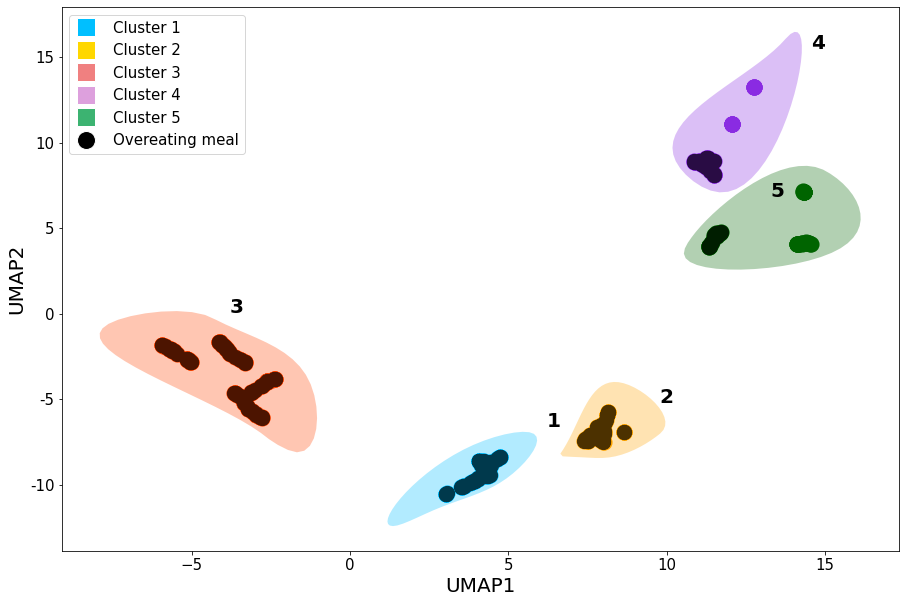

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy import interpolate
from matplotlib.lines import Line2D


# Load the res_df_nnout_umap3d_clustered CSV file
res_df_nnout_umap2d_clustered = pd.read_csv('res_df_nnout_umap2d_clustered.csv')

# Map old cluster labels to new ones
cluster_mapping = {4: 1, 22: 2, 7: 3, 15: 4, 28: 5}

# Apply the mapping to the 'clus_label' column
res_df_nnout_umap2d_clustered['clus_label'] = res_df_nnout_umap2d_clustered['clus_label'].map(cluster_mapping)

# Designate the new clusters to include
overeating_clusters = [1, 2, 3, 4, 5]

# Filter the dataframe for the selected clusters
filtered_df = res_df_nnout_umap2d_clustered[res_df_nnout_umap2d_clustered['clus_label'].isin(overeating_clusters)]
label_filtered = filtered_df['clus_label']

# Set up the plot
fig, axarr = plt.subplots(figsize=(15, 10))

# Set colors for the hulls and corresponding points
cluster_colors = ['deepskyblue', 'orange', 'orangered', 'blueviolet', 'darkgreen']
overeating_face_color = 'black'
overeating_edge_color = 'black'

# Define hull expansion factors for specific clusters
hull_expansion_factors = {
    1: 2.5,
    2: 2.5,
    3: 1.75,
    4: 1.75,
    5: 1.5
}

### Plot the selected clusters
for i, group in enumerate(overeating_clusters):
    # Mask to separate sets
    mask = (label_filtered == group).values
    
    # Scatter plot with hull colors for the points
    axarr.scatter(x=filtered_df[mask]['UMAP_3_1'],
                  y=filtered_df[mask]['UMAP_3_2'],
                  color=cluster_colors[i],  # Match the color of the points to the hulls
                  s=200,  # Fixed size for all points
                  label=f"Cluster {group}", alpha=1, linewidths=2)
    
    # Plot overeating meals as black circles with fixed size (s=200)
    series = (res_df_nnout_umap2d_clustered['obj_oe_flag'] == 1) & (res_df_nnout_umap2d_clustered['clus_label'] == group)
    overeating_meals = res_df_nnout_umap2d_clustered[series]
    axarr.scatter(overeating_meals['UMAP_3_1'],
                  overeating_meals['UMAP_3_2'],
                  facecolor=overeating_face_color, 
                  edgecolor=overeating_edge_color, 
                  s=200,  # Fixed size for overeating meals
                  marker='o')
    
    # Set the hull expansion factor based on cluster number
    hull_expansion_factor = hull_expansion_factors.get(group, 2)  # Default to 2 if not specified
    
    # Convex hull
    points = filtered_df[filtered_df.clus_label == group][['UMAP_3_1', 'UMAP_3_2']].values
    if len(points) >= 3: 
        # Calculate the center of the points
        center = points.mean(axis=0)
        
        # Expand the points away from the center
        expanded_points = (points - center) * hull_expansion_factor + center
        hull = ConvexHull(points)
        x_hull = np.append(expanded_points[hull.vertices, 0], expanded_points[hull.vertices, 0][0])
        y_hull = np.append(expanded_points[hull.vertices, 1], expanded_points[hull.vertices, 1][0])
        
        # Interpolate
        dist = np.sqrt((x_hull[:-1] - x_hull[1:]) ** 2 + (y_hull[:-1] - y_hull[1:]) ** 2)
        dist_along = np.concatenate(([0], dist.cumsum()))
        spline, u = interpolate.splprep([x_hull, y_hull], u=dist_along, s=0, per=1)
        interp_d = np.linspace(dist_along[0], dist_along[-1], 50)
        interp_x, interp_y = interpolate.splev(interp_d, spline)
        
        # Plot convex hull shape
        axarr.fill(interp_x, interp_y, cluster_colors[i], '--', alpha=0.3)  # Use the same colors for hulls and points

     # Sample two random points from each cluster for annotation
    tmp = filtered_df[filtered_df['clus_label'] == group].sample(1)
    
    # Annotate random points with the cluster label, moving the annotation outside the hull
    for _, row in tmp.iterrows():
        axarr.annotate(f"{group}", (row['UMAP_3_1'] + 2, row['UMAP_3_2'] + 2),  # Adjust these values to move the text
                       size=20, weight='bold', color='k', ha='center', va='bottom')

# Customize plot appearance
axarr.set_xlabel('UMAP1', fontsize=20)
axarr.set_ylabel('UMAP2', fontsize=20)
axarr.tick_params(axis='x', labelsize=15)
axarr.tick_params(axis='y', labelsize=15)
y_ticks = np.array([   -10,   -5 ,   0,  5,  10,   15]) # Adjust num for more or fewer labels
axarr.set_yticks(y_ticks)
axarr.set_yticklabels([f'{int(tick)}' for tick in y_ticks])  # Format the tick labels

# Custom legend with manually chosen colors for the dots
custom_legend_colors = ['deepskyblue', 'gold', 'lightcoral', 'plum', 'mediumseagreen']

# Create custom legend handles using Line2D
legend_handles = [
    Line2D([0], [0], marker='s', color='w', markerfacecolor=custom_legend_colors[i], markersize=30, label=f"Cluster {overeating_clusters[i]}")
    for i in range(len(overeating_clusters))
]

# Add a black dot for "Overeating meal" to the legend
legend_handles.append(Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=30, label="Overeating meal"))

# Set up the custom legend
axarr.legend(handles=legend_handles, fontsize=15, markerscale=0.6, scatterpoints=1, 
             handletextpad=1, handlelength=1.5, handleheight=0.8)

# Save the figure
fig.savefig('filtered_clustering_fig.pdf', format = 'pdf')
print("Successfully saved filtered cluster map to 'filtered_clustering_fig.png'\n")